# Test results

This Notebook loads the results (list of detections) generated by the model, and computes some metrics ans visualizations using them

This directory contains a copy of the Medical Detection Toolkit (https://github.com/MIC-DKFZ/medicaldetectiontoolkit/tree/torch1x) slightly adapted to the problem of prostate lesion detection. 

Before running this Notebook, make sure to:
 - Go to https://github.com/MIC-DKFZ/medicaldetectiontoolkit/tree/torch1x and read the instructions in order to be able to run the Toolkit. These instructions have also been cloned to this repository, in `README.md`
 - The current experiment can be found in `experiments\exp0`.
 - In file ``experiments\exp0\config.py``, the paths pointing to the data might need to be updated:
  - ``self.root_dir``
  - ``self.pp_dir``
 - Train the model and test it: `%run exec.py --mode train_test --exp_source experiments/exp0 --exp_dir experiments/exp0`
 - Generate the final test results from the ensemble of trained models: `%run exec.py --mode analysis --exp_source experiments/exp0 --exp_dir experiments/exp0`

Load `plot_lib` (https://github.com/OscarPellicer/plot_lib)

In [22]:
from pathlib import Path
import sys, os
sys.path.append(os.path.join(Path.home(), 'plot_lib'))
from plot_lib import plot, plot_multi_mask
from IPython.display import display, HTML
br= lambda: print(' '*150)
CSS = """output_subarea { flex-direction: row; flex-wrap: wrap; }
         .output { flex-direction: row; flex-wrap: wrap; }
         .widget-hslider { width: auto !important}"""
HTML('<style>{}</style>'.format(CSS))

Load other required libraries

In [23]:
#Import required libs
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import pickle
import numpy as np

from result_computation_lib import (plot_patient, compact_class_detections, composite_score, 
                                    plot_auc, get_optimal_thresholds, match_lesions, gen_dsc)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt

SPACING= (0.5, 0.5, 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


These are the main configuration parameters for the analysis of the results

In [24]:
GGG_THRESHOLD= 2     #Mark lesions as significant if their GGG is >= GGG_THRESHOLD
HOLD_OUT= True       #Should be True
ENSEMBLE_FOLDS= True #Set to true load results from fold ensembling
FOLD= 3              #Fold to use if ENSEMBLE_FOLDS == False
USE_RAW= False       #Use raw predictions (before WBC)
SUBSET= '_test'      #Must be renamed manually if any subset is to be specified here
N_classes= 4         #GGG0, GGG1, GGG2, GGG3+
CLASS_WEIGHTS= {0:-1, 1:-1, 2:1*12.70/17.28, 3:1, 4:1} #Model classes: BG, GGG0, GGG1, GGG2, GGG3+
CLASS_CONFIDENCE_THRESHOLD= 0.2 #Lesions below the threshold are marked as being class 0 (NOT USED)
USE_MODEL= 'experiments/exp0/'
    
print('Using model located at:', USE_MODEL, 'Subset:', SUBSET)
if not ENSEMBLE_FOLDS:
    print('Using Fold %d'%FOLD)
    print(np.load('%s/fold_%d/epoch_ranking.npy'%(USE_MODEL, FOLD)))
else:
    print('Using model ensembling')
    
sys.path.append(USE_MODEL)
from configs import configs
cf= configs()

Using model located at: experiments/exp0/ Subset: _test
Using model ensembling


First, we load all necessary data:
 - `test_results_list`: Contains the predictions from the model
 - `patient_info`: Contains the GTs

In [25]:
#This is all the data that we will need to read
if not ENSEMBLE_FOLDS:
    test_results_list= pd.read_pickle('%s/fold_%d/%s_pred_boxes_%slist.pickle'%(
        USE_MODEL, FOLD, 'processed' if not USE_RAW else 'raw', 'hold_out_' if HOLD_OUT else ''))
else: 
    test_results_list= pd.read_pickle('%s/test/%s_pred_boxes_overall_hold_out_list%s.pickle'%(
        USE_MODEL, 'processed' if not USE_RAW else 'raw', SUBSET))

#Load info of the lesions
patient_info= pd.read_pickle(os.path.join(cf.pp_dir, 'info_df.pickle'))
patient_info= patient_info.set_index('pid')  

Then, we will create a dataframe `patient_df` with patient-wide results (combined as the maximum score of all individual lesions)

In [26]:
ignore_first_N_classes= 1 #Ignore first class (bening)
data= []
for pix, patient_results in enumerate(test_results_list):
    #Extract patient results
    pid, boxes= patient_results[1], patient_results[0]['boxes'][0]

    #Get det boxes scores (& coords) sorted by score and divided by class
    scores_all= [sorted( [[b['box_score'], b['box_coords']] 
                          for b in boxes if b['box_type'] == 'det' and b['box_pred_class_id'] == cl], 
                       key=lambda a: a[0], reverse=True)
                            for cl in range (1 + ignore_first_N_classes, N_classes + 1)]
    score_per_class= [scores[0][0] if len(scores) else 0. for scores in scores_all]
    z_slice_per_class=  [(scores[0][1][4] + scores[0][1][5])/2 if len(scores) else None for scores in scores_all]
    detected_class= np.argmax(score_per_class) + 1
    detected_class_thresholded= detected_class if max(score_per_class) > CLASS_CONFIDENCE_THRESHOLD else 0
    
    #The score depends on the GGG_THRESHOLD
    score= max(score_per_class[GGG_THRESHOLD - ignore_first_N_classes:])
    
    #Find the z-axis to which the max-scoring lesions from each category belong
    
    #Add to list
    data.append( [pid, score, detected_class, detected_class_thresholded, *score_per_class, *z_slice_per_class] )
    
patient_df= pd.DataFrame(data=data, columns=['pid', 'pred_score', 'det_class', 'det_class_thresholded', 
                                     'GGG1_score', 'GGG2_score', 'GGG3+_score', 'z1', 'z2', 'z3+']).set_index('pid')
#patient_df

### Plot patients

Load processed results and plot them patient by patient.

Only the highest-scoring prediction from highly overlapped predictions is being plotted. Change `match_iou` to 1. in `compact_class_detections` to plot all predictions.

In [27]:
#Keep only non-ovelapping (mostly) predictions. Set match_iou=1 to disable it
#Default: benign_class=1 (i.e. class 0)
test_results_list_compacted= compact_class_detections(test_results_list, match_iou=0.25, 
                                                      benign_class=1, class_weights=CLASS_WEIGHTS)

for pix, patient_results in enumerate(test_results_list_compacted):    
    #Get and print patient data:
    pid= patient_results[1]
    
    #Stop after the fifith
    if pix == 5: break
    
    #Print some info
    pat_df= patient_info.loc[pid, :]
    print('%d: %s | Lesion GGGs: %s'%
          (pix, pid, pat_df.class_target))
    print('Max scores: GGG1: %.2f | GGG2: %.2f | GGG3+: %.2f'%
            tuple(patient_df.loc[pid, ['GGG1_score', 'GGG2_score', 'GGG3+_score']].values.tolist()) )
    br()
    
    #Show plot at highest scoring lesion
    z= np.round(patient_df.loc[pid, ['z0', 'z1', 'z2', 'z3+'][patient_df.loc[pid, 'det_class']]])
    z= 12 if np.isnan(z) else z
    
    #Plot
    plot_patient(patient_results, cf.pp_test_data_path, N_classes= N_classes, seg_threshold=0.5, 
                 min_threshold= 0.08, plot_max_per_class=100, spacing=SPACING, scale='auto', ct=0, z=z, 
                 dpi=100, text_kwargs={'linespacing':0.9},
             class_colors={i:plt.get_cmap('Paired')(ci) for i, ci in enumerate(np.arange(0, 1, step=1/(N_classes + 2)))})

0: ProstateX-0001 | Lesion GGGs: [1]
Max scores: GGG1: 0.19 | GGG2: 0.24 | GGG3+: 0.16
                                                                                                                                                      


interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

1: ProstateX-0003 | Lesion GGGs: [10, 10]
Max scores: GGG1: 0.04 | GGG2: 0.02 | GGG3+: 0.00
                                                                                                                                                      


interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

2: ProstateX-0010 | Lesion GGGs: [10]
Max scores: GGG1: 0.11 | GGG2: 0.14 | GGG3+: 0.05
                                                                                                                                                      


interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

3: ProstateX-0018 | Lesion GGGs: [2]
Max scores: GGG1: 0.32 | GGG2: 0.20 | GGG3+: 0.31
                                                                                                                                                      


interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

4: ProstateX-0022 | Lesion GGGs: [10]
Max scores: GGG1: 0.02 | GGG2: 0.04 | GGG3+: 0.01
                                                                                                                                                      


interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='c/t', max=7, style=SliderStyle(…

### Prostatex-like lesion-level results

Detections must be matched with ground truth lesions to get the lesion-level results. They can be matched either by looking at the intersection of their bounding boxes, or by looking at their distance (``USE_DISTANCE= True``). In both cases, the highest-score non-benign lesion from the matched lesions is considered as the score for that lesion.

In [28]:
USE_DISTANCE= True #Use distance instead of IoU for matching lesions
DISTANCE_THRESHOLD= 15 #Consider lesions within a 15mm radius of the GT lesion
threshold_list= [] #[0.4, 0.2, 0.1, 0.05, 0.025]

Lesion-level (prostatex-like). Sig if GGG >= 2
  ProstateX
    N= 69    AUC  | Acc.   | Sens.  | Specif.
    t=0.38: 0.890 |  0.870 |  0.308 |  1.000
    t=0.09: 0.890 |  0.855 |  0.923 |  0.839
    t=0.09: 0.890 |  0.855 |  0.923 |  0.839


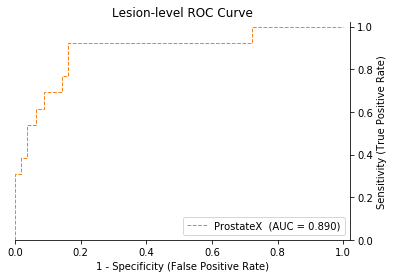

In [29]:
#First, we expand the list of lesions of patient_info, setting their oreder as a lesion index
#We do it by hand to make sure that lists are expanded in order, so that lesion_id can be added
data= []
for row in patient_info.itertuples():
    lst = row[1]
    for i,col2 in enumerate(lst):
        data.append([row[0], i, col2, row[-1]])
        
patient_info_expanded = pd.DataFrame(data=data, columns=['pid', 'lesion_id', 'class_target', 'massive_class_target'])

#Keep from patient info only the patients in test set
pids= [p[1] for p in test_results_list]
patients_test= patient_info_expanded.loc[patient_info_expanded.pid.isin(pids),].set_index(['pid', 'lesion_id'])
patients_test['score']= 0.
patients_test.loc[patients_test.class_target == 10.,:]= 0.
patients_test.loc[patients_test['massive_class_target'].isna(), 'massive_class_target']= -1
patients_test['ClinSig']= patients_test['class_target'] >= GGG_THRESHOLD
patients_test['ClinSig2']= np.nan
patients_test['det_class']= 1
columns_to_keep= ['ClinSig', 'ClinSig2', 'massive_class_target', 'class_target', 'score']
patients_test= patients_test[columns_to_keep]

#Match lesions
patients_test= match_lesions(test_results_list, patients_test, drop_nans=True, class_col='det_class', 
                             cl=GGG_THRESHOLD + 1,  match_iou= 1e-5, spacing=SPACING,
                             use_distance=USE_DISTANCE, distance_threshold=DISTANCE_THRESHOLD )
patients_test['det_class']-= 1 #To make it correspond with GGG
patients_test.loc[patients_test.det_class.isna(), 'det_class']=0
patients_test['det_class']= patients_test['det_class'].astype(int)
patients_test['det_class_thresholded']= patients_test['det_class']
patients_test.loc[patients_test['score'] < CLASS_CONFIDENCE_THRESHOLD, 'det_class_thresholded']= 0

#Prepare more dataframes in case that we want to individualize
patients_test_prostatex= patients_test.loc[
    patients_test.index.isin([p for p in patients_test.index.get_level_values(0) 
                              if p.lower().startswith('prostatex') and int(p[-4:]) < 204], level=0), :]

#print results at different thresholds
print('Lesion-level (prostatex-like). Sig if GGG >= %d'%GGG_THRESHOLD)
for plot_subset, name in zip([patients_test_prostatex], ['ProstateX']):
    print(' ', name)
    print('    N=%3d    AUC  | Acc.   | Sens.  | Specif.'%(len(plot_subset)))
    for t in threshold_list + [*get_optimal_thresholds(plot_subset.ClinSig, plot_subset.score)]:
        print('    %s: %.3f |  %.3f |  %.3f |  %.3f'%('t=%.2f'%t, *composite_score(
            plot_subset.ClinSig, plot_subset.score, t=t)))

    #Plot AUC
    plot_auc(plot_subset.ClinSig, plot_subset.score, new_fig=name=='All', legend=name + ' ', annotate=False)
    
_=plt.title('Lesion-level ROC Curve')
#plt.gcf().savefig('lesion_auc.png', dpi=300)

### Patient-level results

The worst lesion result for a given patient is taken as the Grount Truth, while the highest scoring non-bening lesion is taken as the prediction score.

Patient-level. Sig if GGG >= 2
  ProstateX
    N= 45    AUC  | Acc.   | Sens.  | Specif.
    t=0.40: 0.814 |  0.800 |  0.308 |  1.000
    t=0.26: 0.814 |  0.822 |  0.692 |  0.875
    t=0.09: 0.814 |  0.689 |  0.923 |  0.594


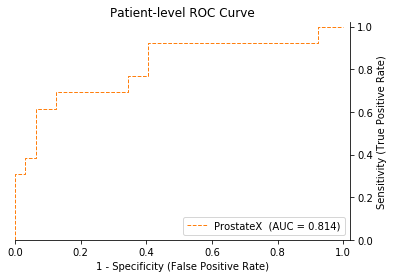

In [30]:
#Prepare two more dataframes in case that we want to individualize
df= patient_df.reset_index()
df_prostatex= df.loc[df.pid.isin([p for p in df.pid if p.lower().startswith('prostatex') and int(p[-4:]) < 204]), :]

#Process dataframes to contain all, prostatex and ivo patients & plot results
print('Patient-level. Sig if GGG >= %d'%GGG_THRESHOLD)
for subset, name in zip([df_prostatex], ['ProstateX']):
    #Fix patients
    spec_df= subset.merge(patient_info, how='left', on='pid')
    def get_worst(l):
        l= np.array(l + [0])
        l= l[l != 10]
        return np.max(l)
    spec_df['lesions_ggg']=  spec_df['class_target'].apply(get_worst)
    spec_df['ggg']= spec_df['lesions_ggg']
    spec_df['ClinSig']= spec_df['ggg'] >= GGG_THRESHOLD
    spec_df.loc[spec_df['pred_score'] < CLASS_CONFIDENCE_THRESHOLD, 'det_class_thresholded']= 0

    #Print results at different thresholds
    print('  %s'%name)
    print('    N=%3d    AUC  | Acc.   | Sens.  | Specif.'%(len(spec_df)))
    for t in threshold_list + [*get_optimal_thresholds(spec_df.ClinSig, spec_df.pred_score)]:
        print('    %s: %.3f |  %.3f |  %.3f |  %.3f'%('t=%.2f'%t, *composite_score(
            spec_df.ClinSig, spec_df.pred_score, t=t)))
        
    #Plot AUC
    plot_auc(spec_df.ClinSig, spec_df.pred_score, new_fig=name=='All', legend=name + ' ', annotate=name=='All')

_=plt.title('Patient-level ROC Curve')
#plt.gcf().savefig('patient_auc.png', dpi=300)

## Compute DSC scores

In [31]:
dice_threshold= 0.25

dscs_prostatex= []
for patient_results, pid in test_results_list:
    seg_p= patient_results['seg_preds'][0] > dice_threshold
    seg_p= np.transpose(seg_p, axes=(2,0,1))
    seg= np.load(os.path.join(cf.pp_test_data_path,'{}_rois.npy'.format(pid)))
    dscs_prostatex.append(gen_dsc(seg, seg_p))
    
metric_name= 'DSC'
for name, metric in zip(['ProstateX'], [dscs_prostatex]):
    print('%10s | %s: mean: %.4f +/- %.4f (N=%d) | median : %.4f | min : %.4f | max : %.4f'%
              (name, metric_name, np.mean(metric), np.std(metric), len(metric), np.median(metric), 
               np.min(metric), np.max(metric)))

 ProstateX | DSC: mean: 0.2705 +/- 0.2231 (N=45) | median : 0.2841 | min : 0.0001 | max : 0.7712


## Compete in ProstateX challenge

To compete in ProstateX, go to `config.py` and set `self.test_set= 'train'`. Then run `exec.py` in `test` mode, and in `analysis` mode after.
You may want to manually rename the previous test results to avoid overwriting them.

**Alternatively**, the predictions are already provided as a zip file in `train_boxes.zip`

You must also set the path to the challenge ``.csv`` test file provided alongside the challenge images.

In [32]:
if 'train' in SUBSET:
    #Load dataset and results
    GGG_THRESHOLD_PROSTATEX= 2 #In prostateX clinically significant prostate cancer is considered as GGG >= 2
    prostatex_test= pd.read_csv('../ProstateX-Findings-Test.csv') #Path to the ProstateX test data

    #Keep only prostatex test patients
    prostatex_test_results_list= [p for p in test_results_list if p[1] in prostatex_test.ProxID.values] 

    #Set a new column 'lesion_id' that contains the actual ID used in the model for each lesion
    prostatex_test['lesion_id']= prostatex_test.groupby('ProxID').cumcount()

    #Set the index to ProxID and fid2
    prostatex_test= prostatex_test.set_index(['ProxID', 'lesion_id'])
    prostatex_test['ClinSig']= 0.
    prostatex_test['ClinSig2']= np.nan #Will be true for all since class=20 > 0

    #Match lesions
    prostatex_test= match_lesions(prostatex_test_results_list, prostatex_test, drop_nans=False, score_col='ClinSig',
                                  cl=GGG_THRESHOLD_PROSTATEX + 1,
                                  use_distance=USE_DISTANCE, distance_threshold=DISTANCE_THRESHOLD, 
                                  spacing=SPACING, normalize_by_distance=False)

    #Save with correct formatting
    prostatex_submission= prostatex_test.reset_index().set_index(['ProxID', 'fid']).sort_index(
                                       ).reset_index()[['ProxID', 'fid', 'ClinSig']]
    prostatex_submission.to_csv('prostatex_submission.csv', index=False)

    #Check that the scores are not all zeros
    prostatex_submission